In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

Немного любопытных набдлюдений про многомерные пространства:

С ростом размерности пространства растет среднее растояние между двумя случайными точками.

(199,) [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200]
(199,)
CPU times: user 14min 46s, sys: 6.03 s, total: 14min 52s
Wall time: 14min 48s


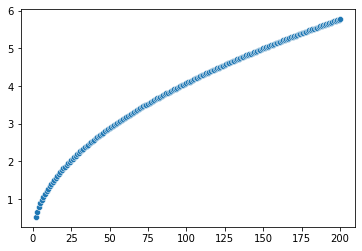

In [ ]:
%%time
def get_two_point_dist(dim=2):
    point_1 = np.random.rand(dim)
    point_2 = np.random.rand(dim)
    dist = np.sqrt(np.sum(np.square(point_1 - point_2,  dtype = np.float),  dtype = np.float), dtype = np.float)
    return dist
num_iter = 300_000
dims = np.arange(2, 201)
print(dims.shape, dims)
srs = np.zeros_like(dims, dtype=np.float)
print(srs.shape)
for i in range(dims.shape[0]):
    s = np.zeros(num_iter, dtype=np.float)
    for j in range(num_iter):
        s[j] = get_two_point_dist(dim=dims[i])
    srs[i] = s.mean()

sns.scatterplot(x=dims, y=srs)

С ростом размерности пространства растет вероятность попасть в крайню точку N мерного куба - на расстояние ближе чем 0,001 к поверхности куба

(199,) [  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200]
(199,)
CPU times: user 15min 27s, sys: 4.52 s, total: 15min 32s
Wall time: 15min 29s


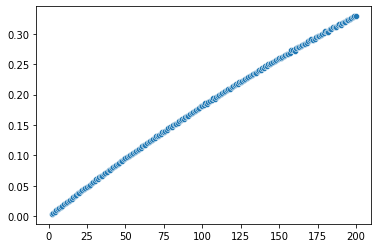

In [ ]:
%%time
num_iter = 300_000
dims = np.arange(2, 201)
print(dims.shape, dims)
srs = np.zeros_like(dims, dtype=np.float)
print(srs.shape)

delta = 0.001
for i in range(dims.shape[0]):
    counter = 0
    for j in range(num_iter):
        point_1 = np.random.rand(dim)
        if ((np.random.rand(dims[i]) < delta).sum() + (np.random.rand(dims[i]) > 1 - delta).sum()) > 0:
            counter += 1
    srs[i] = counter / num_iter
sns.scatterplot(x=dims, y=srs)

## <center> Методы понижения размерности

### 1. Метод главных компонент (PCA)

**Метод главных компонент (Principal Component Analisys, PCA)** - метод машинного обучения без учителя, который позволяет снизить размерность данных, стараясь при этом потерять как можно меньше информации через вычисление так называемых ***главных компонент***.

**Зачем может понадобится снижать размерность данных?**
1. Для визуализи данных - данные с большим количеством признаком сложно визуализировать. PCA может сжать данные до двух признаков, которые удобно визуализировать в двумерном пространстве
2. Для снижения количества пизнаков - стараемся найти признаковое пространство меньшего размера, которое будет лучше отражать взаимосвязи в данных
3. Избавление от шума в данных


**В чем идея метода?**

На картинке в верхнем левом углу изображены исходные данные, для которых заданы два признака (отложены по осям Х и Y). Видно, что есть довольно сильная корреляция между признаками. Метод предполагает такие шаги:

1. Находим направление в данных с максимальной дисперсией (разбросом). Именно оно содержить наибольшую информацию, т.к. вдоль него наибольшая корреляция. Это и будет **Первая главная компонента**.
2. Находим второе направление, которое содержит наибольшую информацию, и при этом ортогонально (перпендикулярно) первому - **Вторая главная компонента**.
3. Повернем данные так, чтобы по осям у нас отложены не признаки, а компоненты: X-первая главная компонента, Y-вторая главная компонента. Такое вращение привело к тому, что теперь корреляция в данных отсутсвует (вверхний правый рисунок). Кроме того, перед поворотом мы отцентрировали данные так, что среднее находится в нуле (вычли из каждого значения среднее).
4. Сейчас у нас количество компонент равняется количеству исходных признаков. Мы не сделали понижение размерности, только повернули систему координат. Попробуем сжать данные. Для этого оставим только наиболее информативную компоненту, таковой является первая (нижний левый рисунок). Вот мы и понизили размерность данных, теперь с ними можно работать.
5. Мы можем вернуть данные обратно в исходное признаковое пространство. Для этого отменим вращение и прибавим среднее (нижний правый рисунок). Мы вернулись в исходное признаквое пространство, но при этом сохранили только часть информации. Обратное возвращение можно делать тогда, когда мы хотим отфильтровать исходные данные.


<img src='https://github.com/MalikaL17/course_materials/blob/main/img/pca.PNG?raw=true'>

**Важные выводы:**
- Главные компоненты отражают основные направления ***диспресии*** данных
- Из пункта выше вытекает, что метод очень ***чувствителен к масштабу*** данных. Если масштаб данных разный, надо обязательно нормировать данные перед применением метода
- После преобразования данных с помощью PCA, оси ***не коррелируют*** между собой

Рассмотрим более подробно, что собой представляют главные компоненты и как их можно интерпретировать.

Главные компоненты - ***линейные комбинация*** исходных признаков. Это можно отразить формулой:

$$ pc = \sum_{i=1}^n\alpha_{i} x_{i}$$
$pc$ - значение  главной компоненты

$\alpha_{i}$ - вес i-го признака в компоненте

$x_{i}$ - значения i-го признака из исходных данных

In [ ]:
df = pd.read_csv('pca.csv')
df.head()

,math,rus
0,46.704934,57.524393
1,68.678641,60.282749
2,58.831524,56.293623
3,75.557776,52.350720
4,71.388141,61.555425


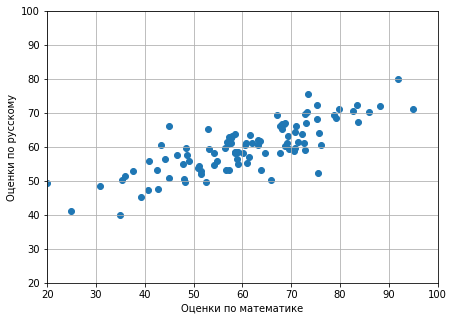

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(df['math'], df['rus']);
plt.xlabel('Оценки по математике');
plt.ylabel('Оценки по русскому');
plt.grid();
plt.xlim(20, 100);
plt.ylim(20, 100);

In [ ]:
# применим PCA к данным
pca = PCA()
pca_data = pca.fit_transform(df[['math', 'rus']])
pca_data = pd.DataFrame(pca_data, columns=['comp1', 'comp2'])

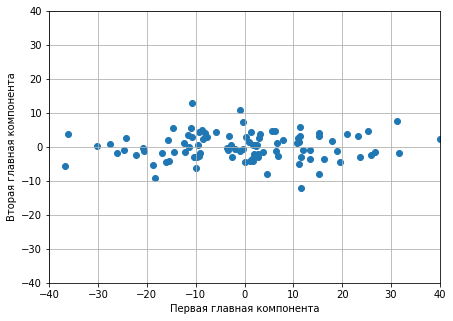

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(pca_data['comp1'], pca_data['comp2']);
plt.grid();
plt.xlim(-40, 40);
plt.ylim(-40, 40);
plt.xlabel('Первая главная компонента');
plt.ylabel('Вторая главная компонента');

Посмотрим на веса признаков в полученных компонентах.
Видно, что в первую компоненту больший вклад вносит математика, обе переменные вносят положительный вклад.
Во вторую больший вклад вносит русский, при этом переменные вносят разнонапрвленный характер.

In [ ]:
# выведем компоненты, отсортированные по важности
pca.components_

array([[-0.91224408, -0.40964708],
       [ 0.40964708, -0.91224408]])

In [ ]:
pca.explained_variance_ratio_

array([0.93676164, 0.06323836])

***Хорошая <a href="http://math-info.hse.ru/f/2015-16/ling-mag-quant/lecture-pca.html"> статья  </a> про PCA и интерпретацию результатов***

**Пример понижения размерности**

Рассмотрим встроеный в sklearn набор данных о онкобольных. Данные разделены на два класса: 1 - доброкачественная опухоль, 0 - злокачественная опухоль.

In [ ]:
from sklearn.datasets import load_breast_cancer, load_digits
cancer = load_breast_cancer()

Данные содержат 30 признаков, что делает визуальный анализ диаграмм рассеяния довольно сложным. Построим гистограммы в развере двух классов, чтобы посмотреть, есть ли различия в признаках для каждого класса.

In [ ]:
cancer.data.shape

(569, 30)

Из гистограмм ниже видно, что по некоторым признакам есть довольно сильное отличие между двумя классами, а по некоторым - нет.
Также эти графики не дают нам никакой информации о взаимодействии между переменными и взаимосвязях между признаками
и классами зависимой переменной. Попробуем использвать PCA, чтобы учесть эти взаимодействия.

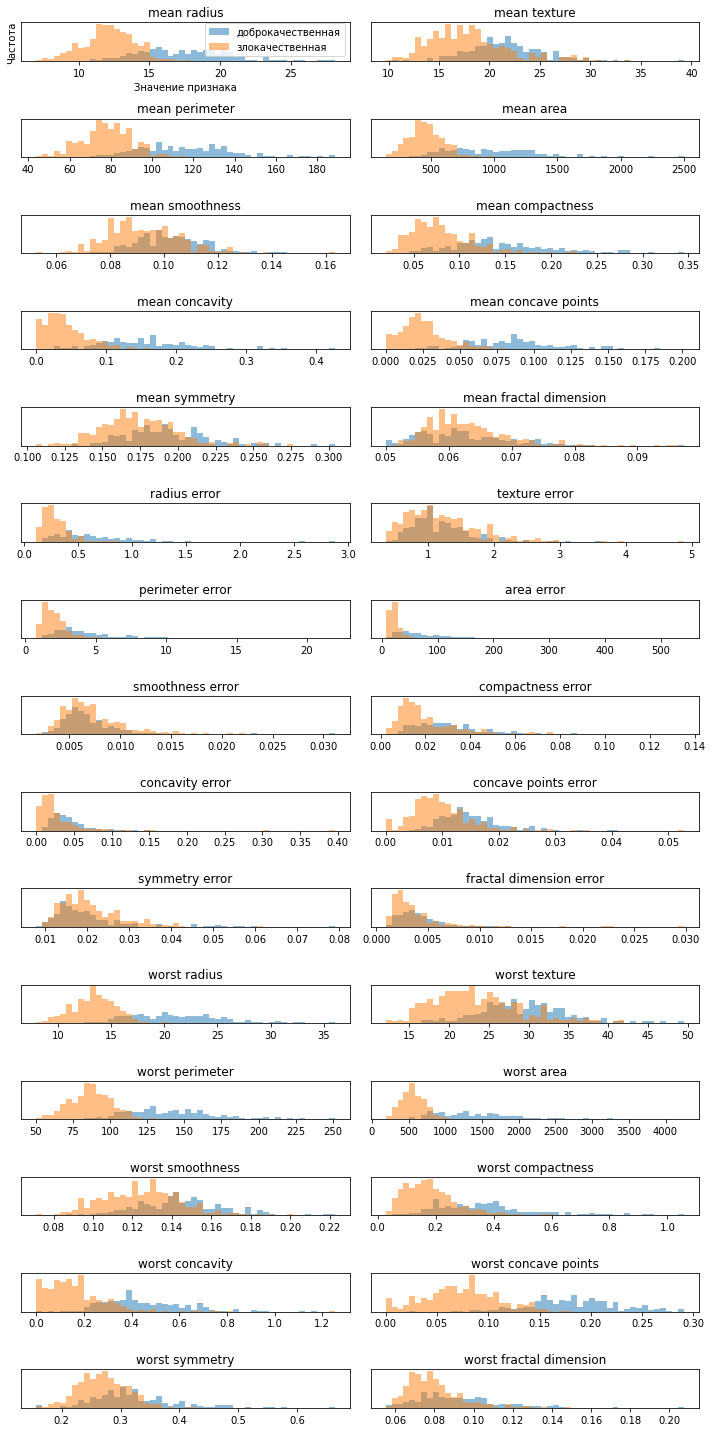

In [ ]:
fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]
ax = axes.ravel()
for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, alpha=.5) # color=mglearn.cm3(0),
    ax[i].hist(benign[:, i], bins=bins,  alpha=.5) # color=mglearn.cm3(2),
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    ax[0].set_xlabel("Значение признака")
    ax[0].set_ylabel("Частота")
    ax[0].legend(["доброкачественная", "злокачественная"], loc="best")
    fig.tight_layout()

In [ ]:
# Масштабируем данные для корректной работы PCA
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [ ]:
# оставляем только 2 компоненты, чтобы удобно было сделать двумерную визуализацию
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [ ]:
X_pca.shape

(569, 2)

Из диаграммы ниже видно, что после уменьшения размерности классы довольно хорошо разделяются линейно. При этом, стоит подчеркнуть, что алгоритм ничего не знал о наличии двух классов, мы просто использовали эту информацию, чтобы раскрасить точки разными цветами.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


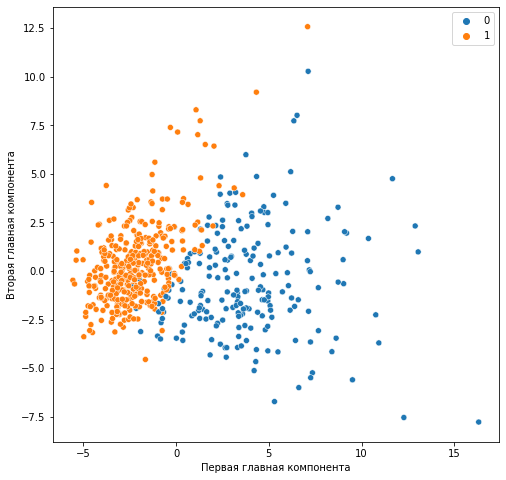

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=cancer.target);
plt.xlabel("Первая главная компонента");
plt.ylabel("Вторая главная компонента");

### PCA при решении задачи классификации

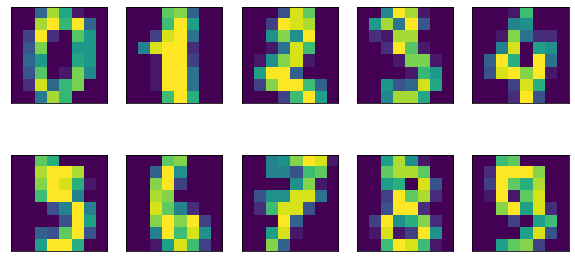

In [ ]:
digits = load_digits()
fig, axes = plt.subplots(2, 5, figsize=(10, 5),
subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

**Бывает сложно указать заранее число компонент, до которого хотим сократить данные. Например, если нас интересует некий конкретный процент качества объяснения данных. Но можно установить процент объясненной дисперсии. Например 0.95. Алгоритм оставит ровно столько компонент, сколько нужно для такого процента объяснения данных**

In [ ]:
pca = PCA(n_components=0.95)
pca.fit(digits.data)
pca.explained_variance_ratio_

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.05782415,
       0.0491691 , 0.04315987, 0.03661373, 0.03353248, 0.03078806,
       0.02372341, 0.02272697, 0.01821863, 0.01773855, 0.01467101,
       0.01409716, 0.01318589, 0.01248138, 0.01017718, 0.00905617,
       0.00889538, 0.00797123, 0.00767493, 0.00722904, 0.00695889,
       0.00596081, 0.00575615, 0.00515158, 0.0048954 ])

In [ ]:
pca.n_components_

29

In [ ]:
from sklearn.svm import LinearSVC
X = digits.data
y = digits.target
svc_1 = LinearSVC().fit(X, y)
svc_1.score(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9782971619365609

In [ ]:
X = digits.data
pca = PCA(n_components=0.95)
X_mini = pca.fit_transform(X)
y = digits.target
svc_2 = LinearSVC().fit(X_mini, y)
svc_2.score(X_mini,y)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9727323316638843

In [ ]:
print(X_mini.shape[1], X.shape[1])
print(f"Сократили количество признаков на {1 - X_mini.shape[1] / X.shape[1]}%")
print(f"Потеряв всего {1 - svc_2.score(X_mini,y) / svc_1.score(X,y)}% качества модели")

29 64
Сократили количество признаков на 0.546875%
Потеряв всего 0.009593679458239301% качества модели


**Обратное превращение**

На примере картинок можно достаточно показательно увидеть - эффективно ли обратное восстановление данных, после их сжатия методом PCA

In [ ]:
X_recovered = pca.inverse_transform(X_mini)

In [ ]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=5, **options):
    size = int(np.sqrt(instances.shape[1]))
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

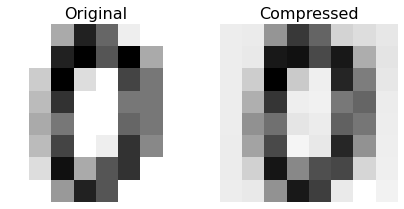

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

**Randomized PCA**

В случае svd_solver="randomized" используется стохастичекий алгоритм, который быстро находит аппроксимацию первых **d** компонент. В случае, если число компонент значительно меньше числа признаков, алгоритм сходится гораздо быстрее.
Автоматически работает метод SVD разложения матрицы, но если число признаков и наблюдений больше 500, а число компонент меньше 80% от числа признаков, то автоматом выбирается метод "randomized".

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [ ]:
rnd_pca.n_components_, rnd_pca.explained_variance_ratio_.sum(), X_train.shape

(154, 0.9500348055830327, (52500, 784))

**Incremental PCA**

В случае трансформации датасетов, которые не помещаются в память, можно применять инкрементальный метод PCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

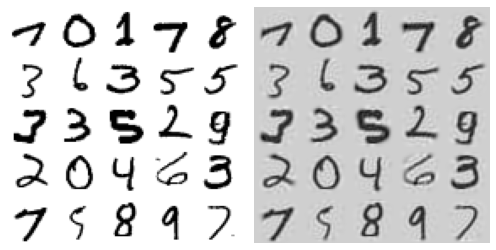

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

**Kernel PCA**

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

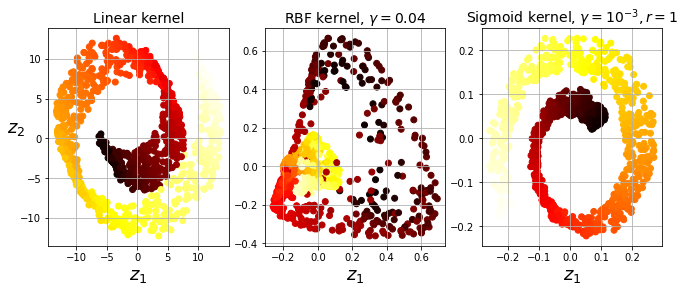

In [ ]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### 2. t-SNE

**t-SNE** (t-distributed stochastic neighbor embedding) - стохастическое вложение соседей с распределением Стьюдента.

В основном метод направлен на **визуализацию**, а не обучение. Он создает новое представление обучающих данных, но при этом не осуществляют преобразования новых данных. Поэтому может применяться только в ***разведочном анализе***.

**Идея метода:**  Найти ***двумерное*** представление данных, которое сохраняет ***расстояния между точками*** наилучшим образом.

**t-SNE** начинает свою работу со случайного двумерного представления каждой точки данных, а затем пытается сблизить точки, которые в пространстве исходных признаков находятся близко друг к другу, и отдаляет друг от друга точки, которые находятся далеко друг от друга.

При этом t-SNE уделяет большее внимание сохранению расстояний между точками, близко расположенными друг к другу. Иными словами, он пытается сохранить информацию, указывающую на то, какие точки являются соседями друг другу.

**Пример**

Рассмотрим пример на картинках цифр, набор данных также встроеный в sklearn. Каждая картинка представляет собой изображение размером 8 на 8 пикселей.

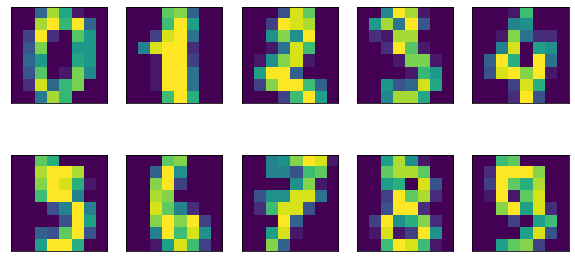

In [ ]:
digits = load_digits()
fig, axes = plt.subplots(2, 5, figsize=(10, 5),
subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

In [ ]:
digits.data.shape

(1797, 64)

In [ ]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

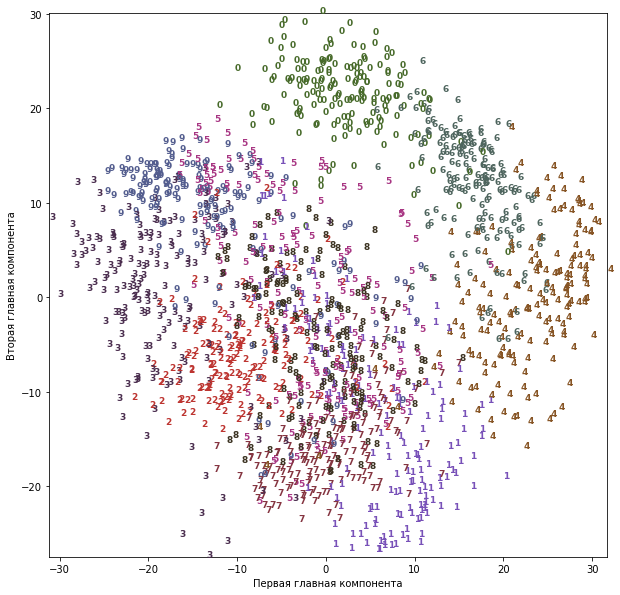

In [ ]:
# строим модель PCA
pca = PCA(n_components=2)
pca.fit(digits.data)
# преобразуем данные рукописных цифр к первым двум компонентам
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525", "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())
for i in range(len(digits.data)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
    color = colors[digits.target[i]],
    fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("Первая главная компонента")
    plt.ylabel("Вторая главная компонента")

PCA неплохо выделил цифры 0, 4 и 6 по первой компоненте, остальные смешались. Посмотрим, как отработает t-SNE.

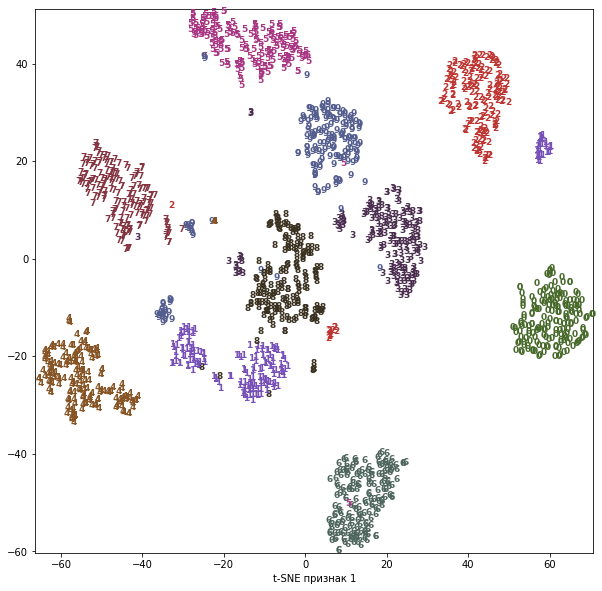

In [ ]:
tsne = TSNE(random_state=42)
# используем метод fit_transform вместо fit, т.к. класс TSNE не использует метод transform
digits_tsne = tsne.fit_transform(digits.data)
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
    color = colors[digits.target[i]],
    fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("t-SNE признак 0")
    plt.xlabel("t-SNE признак 1")

CPU times: user 1.08 s, sys: 220 ms, total: 1.3 s
Wall time: 1.07 s


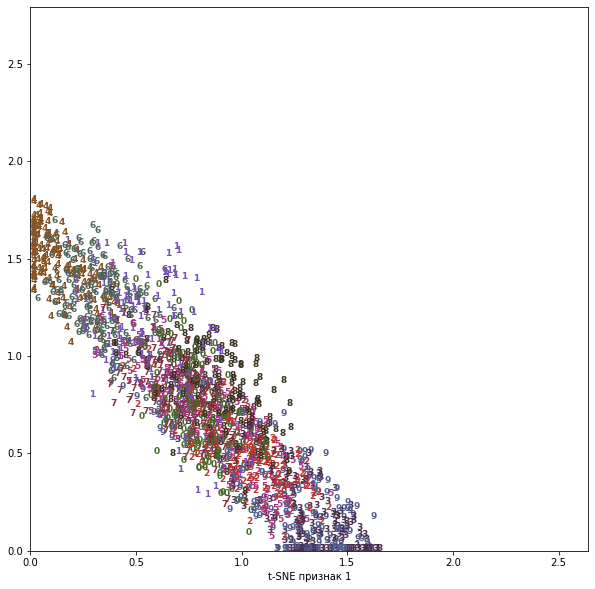

In [ ]:
%%time
from sklearn.decomposition import NMF

nmf = NMF(n_components=2)
# используем метод fit_transform вместо fit, т.к. класс TSNE не использует метод transform
digits_tsne = nmf.fit_transform(digits.data)
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits.data)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
    color = colors[digits.target[i]],
    fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("t-SNE признак 0")
    plt.xlabel("t-SNE признак 1")

**Не все так просто!**

Результат работы t-SNE может сильно зависеть от параметров.

Например, от параметра ***perplexity*** - количество ближайших соседей. Оптимальными считаются значения от 5 от 50. На рисунке ниже представлены результаты работы алгоритма при разных значениях параметра.

<img src='https://github.com/MalikaL17/course_materials/blob/main/img/tsne_perplexity.PNG?raw=true'>

Кроме того, при слишком маленьком значении этого параметра можно увидеть кластеры там, где на самом деле их нет и данные случайны

<img src='https://github.com/MalikaL17/course_materials/blob/main/img/tsne_random.PNG?raw=true'>

Также важныйм параметром является количество итераций. При недостаточном количестве итераций алгоритм может остановить работу до того, как найдет устойчивое решение

<img src='https://github.com/MalikaL17/course_materials/blob/main/img/tsne_steps.PNG?raw=true'>


**Больше примеров того, как t-SNE зависит от параметров можно найти в <a href="https://distill.pub/2016/misread-tsne/"> статье </a>**

### 3. LLE - Локальное линейное вложение

Не смотря на своеё название является методом НЕлинейного понижения размерности

Сначала измеряет, как каждый обучающий образец линейно связан со своими ближайшими соседями, и затем ищет представление обучающего наборас меньшим количеством измерений, где такие локальные связи лучше всего сохраняются

Очень эффективен при развертывании скрученных многообразий

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)


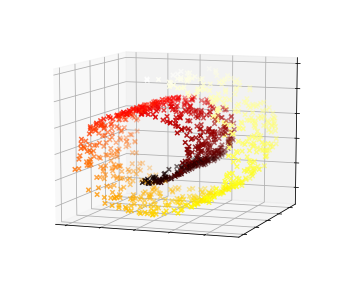

In [ ]:
plt.figure(figsize=(6, 5))

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.show()

In [ ]:
%%time
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X)

CPU times: user 253 ms, sys: 273 ms, total: 526 ms
Wall time: 318 ms


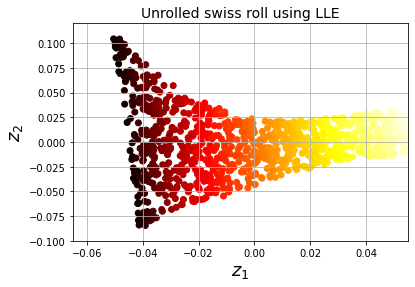

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

### Другие методы понижения размерности

Многомерное шкалирование. Понижает размерность, одновременно пытаясь сохранить расстояние между образцами

In [ ]:
%%time
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

CPU times: user 37.5 s, sys: 27.2 s, total: 1min 4s
Wall time: 33.2 s


Изометрические отображения. Создает граф, соединяя каждый образец с его ближайшими соседями и затем понижает размерность, одновременно пытаясь сохранить геодезическое расстояние (количество ребер между вершинами графа) между образцами

In [ ]:
%%time
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

CPU times: user 340 ms, sys: 22.1 ms, total: 363 ms
Wall time: 346 ms


In [ ]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

CPU times: user 12.6 s, sys: 173 ms, total: 12.7 s
Wall time: 6.52 s


Факторизация неотрицательных матриц.

Он работает так же, как PCA, а также его можно использовать для уменьшения размерности. Как и в РСА, мы пытаемся записать каждую точку данных в виде взвешенной суммы некоторых компонентов. Однако, если в PCA нам нужно получить ортогональные компоненты, объясняющие максимально возможную долю дисперсии данных, то в NMF нам нужно получить неотрицательные компоненты и коэффициенты, то есть нам нужны компоненты и коэффициенты, которые больше или равны нулю. Поэтому этот метод может быть применен только к тем данным, в которых характеристики имеют неотрицательные значения, поскольку неотрицательная сумма неотрицательных компонентов не может быть отрицательной.

In [ ]:
%%time
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X)

CPU times: user 2.99 ms, sys: 4.22 ms, total: 7.2 ms
Wall time: 8.09 ms


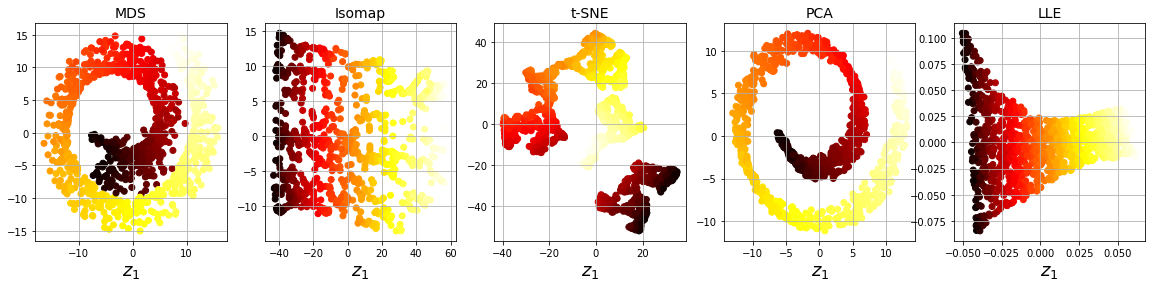

In [ ]:
titles = ["MDS", "Isomap", "t-SNE", "PCA", "LLE"]

plt.figure(figsize=(24,4))

for subplot, title, X_reduced in zip((161, 162, 163, 164, 165), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne, X_reduced_pca, X_reduced_lle)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()